In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
import tensorflow_io as tfio
import soundfile as sf
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from functools import partial

from data import fetch_metadata,load_wav_for_map, load_wav_16k_mono, bird_mapping_idx_to_name, align, loudness_normalization
from yamnet import Yamnet

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
yamnet_base = Yamnet()
yamnet_class_names = yamnet_base.yamnet_class_names

In [22]:
# waveform = tf.io.read_file('/media/wwymak/Storage2/birdsong_dataset/xeno_canto_eu_cleaned/great_tit/206520.wav')
# waveform, sample_rate = tf.audio.decode_wav(waveform)
# # audio = tf.squeeze(audio, axis=-1)
# waveform = tf.cast(waveform, tf.float32)
# waveform = tfio.audio.resample(
#     waveform, rate_in=tf.cast(sample_rate, tf.int64), rate_out=16_000, name=None
# )
# mask = tf.greater(tf.abs(waveform), 0.0005)
# waveform = tf.boolean_mask(waveform, mask)
# waveform = loudness_normalization(align(tf.reshape(waveform, (-1, 1))))
waveform = load_wav_16k_mono('/media/wwymak/Storage2/birdsong_dataset/xeno_canto_eu_cleaned/dunlin/371999.wav')
scores, embeddings, spectrogram = yamnet_base.model(waveform)
# waveform = tf.where(mask, waveform, tf.zeros_like(waveform))
# scores, embeddings, spectrogram = yamnet_base.model(tf.squeeze(waveform, axis=[-1]))

scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()


In [23]:
Audio(waveform[:16000 * 5],rate=16000)

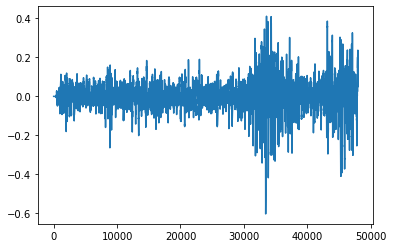

In [24]:
plt.plot(waveform[:16000 * 3])

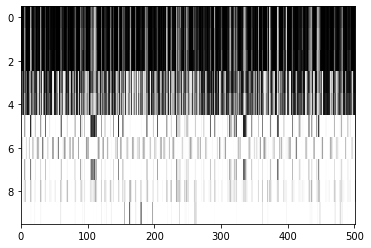

In [9]:
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.imshow(scores_np[:, top_class_indices].T[:, 0:int(16000 * 3/4.8)], aspect='auto', interpolation='nearest', cmap='gray_r')

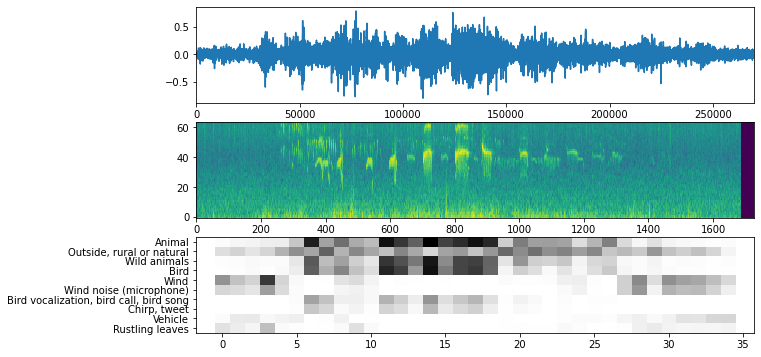

In [25]:
plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [yamnet_class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))

In [26]:
bird_indices = [idx for idx in range(len(yamnet_class_names)) if yamnet_class_names[idx] in ['Bird',
 'Bird vocalization, bird call, bird song',
 'Chirp, tweet']]

In [36]:
scores_np[:, bird_indices].min()

5.0059778e-05

In [51]:
# grab slices where there's a bird detected by yamnet
bin_width = int(16000 * 0.48)
valid_sects = np.unique(np.argwhere(scores_np[:, bird_indices]>= 0.15)[:, 0])
mask = np.concatenate([np.arange(x * bin_width, (x + 1)* bin_width) for x in valid_sects])
mask.shape

(107520,)

In [52]:
mask.astype(int).shape, waveform.numpy().shape, mask.max(), scores_np[:, bird_indices].shape

((107520,), (270001,), 207359, (35, 3))

In [53]:
valid_sects

array([ 6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 20, 26])

(0.0, 107520.0)

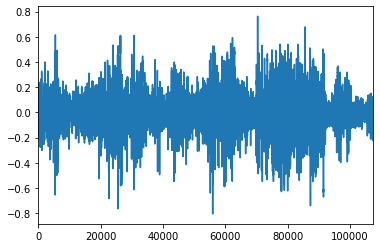

In [54]:
waveform_transformed = waveform.numpy()[mask]
plt.plot(waveform_transformed)
plt.xlim([0, len(waveform_transformed)])

In [55]:
Audio(waveform_transformed, rate=16000)

In [56]:
Audio(waveform, rate=16000)

In [57]:
embeddings.shape

TensorShape([35, 1024])

In [4]:
waveform_len = tf.size(waveform)
pad_length = tf.maximum(16000 * 30 - tf.size(waveform), 0)
print(pad_length)
pad_repeats = tf.cast(tf.math.ceil(pad_length / waveform_len), tf.int32)
print(pad_repeats)
tf.tile(waveform, [pad_repeats+1])

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)


<tf.Tensor: shape=(3862287,), dtype=float32, numpy=
array([-9.1611082e-07,  1.8015361e-06,  6.8999668e-08, ...,
        1.5455198e-02,  1.4592649e-02,  2.1035023e-02], dtype=float32)>

In [4]:


# testing_wav_data = load_wav_16k_mono('/media/wwymak/Storage2/birdsong_dataset/xeno_canto_eu_cleaned/great_tit/122771.wav')

# _ = plt.plot(testing_wav_data)

# # Play the audio file.
# Audio(testing_wav_data,rate=16000)

In [12]:
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]


In [10]:
[x for x in yamnet_class_names if ('bird' in x.lower() or 'chirp' in x.lower())]

['Bird',
 'Bird vocalization, bird call, bird song',
 'Chirp, tweet',
 'Bird flight, flapping wings',
 'Chirp tone']

In [14]:
bird_indices = [idx for idx in range(len(yamnet_class_names)) if yamnet_class_names[idx] in ['Bird',
 'Bird vocalization, bird call, bird song',
 'Chirp, tweet']]

In [15]:
bird_indices

[106, 107, 108]

In [13]:
[yamnet_class_names[x] for x in top_class_indices]

['Animal',
 'Wild animals',
 'Bird',
 'Cricket',
 'Bird vocalization, bird call, bird song',
 'Frog',
 'Chirp, tweet',
 'Insect',
 'Squeal',
 'Noise']

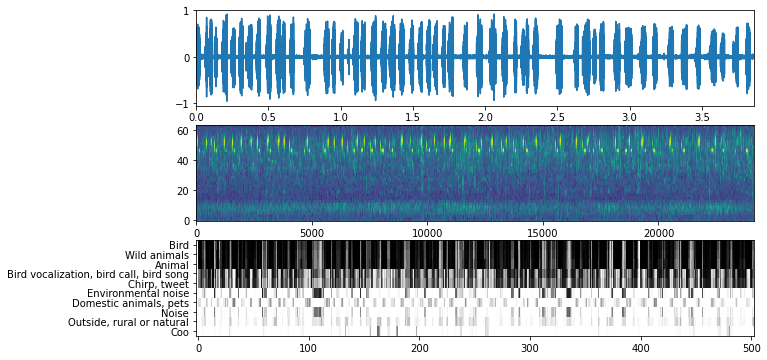

In [8]:
plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [yamnet_class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))

In [16]:
from data import denoise, align, loudness_normalization

In [30]:
pad_length = tf.maximum((16000 * 30 - tf.size(waveform)), 0)
tf.math.ceil(pad_length / tf.size(waveform) )

<tf.Tensor: shape=(), dtype=float64, numpy=5.0>

In [63]:
test = align2(waveform, seq_len=30 * 16000)
test.shape

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'Need value.shape >= size, got '
369472
480000

In [85]:
samples = tf.squeeze(waveform)
samples = tf.concat([samples] * (5 + 1), axis=0)
test = tf.image.random_crop(tf.reshape(samples, (-1,1)), [16000*30, 1])

In [98]:
# test = align2(waveform, seq_len=30 * 16000)
# test.shape
waveform_len =  tf.size(waveform)
pad_length = tf.maximum(seq_len - tf.size(waveform), 0)
pad_repeats = tf.cast(tf.math.ceil(pad_length / waveform_len), tf.int32)
print(pad_repeats.numpy())
samples = tf.squeeze(tf.concat([waveform] * (pad_repeats.numpy() + 1), axis=0))
print(samples.shape)

5
(554208,)


In [99]:
def align2(waveform: tf.Tensor, seq_len: int):
    waveform_len =  tf.size(waveform)
    pad_length = tf.maximum(seq_len - tf.size(waveform), 0)
    pad_repeats = tf.cast(tf.math.ceil(pad_length / waveform_len), tf.int32)
    print(pad_repeats)
    samples = tf.squeeze(tf.concat([waveform] * (pad_repeats.numpy() + 1), axis=0))
    print(samples.shape)
    samples = tf.image.random_crop(tf.reshape(samples, (-1,1)), [seq_len, 1])
    return tf.squeeze(samples)

(92368,)
tf.Tensor(5, shape=(), dtype=int32)
(554208,)


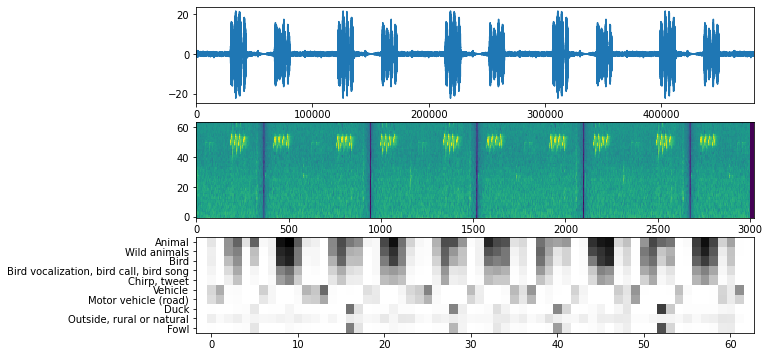

In [104]:
waveform = tf.io.read_file('/media/wwymak/Storage2/birdsong_dataset/xeno_canto_eu_cleaned/great_tit/112218.wav')
waveform, sample_rate = tf.audio.decode_wav(waveform)
# audio = tf.squeeze(audio, axis=-1)
waveform = tf.squeeze(waveform, axis=-1)
sample_rate = tf.cast(sample_rate, dtype=tf.int64)
waveform = tfio.audio.resample(waveform, rate_in=sample_rate, rate_out=16000)
print(waveform.shape)  

waveform = align2(waveform, seq_len=30 * 16000)

waveform = loudness_normalization(waveform)


scores, embeddings, spectrogram = yamnet_base.model(waveform)
# waveform = tf.where(mask, waveform, tf.zeros_like(waveform))
# scores, embeddings, spectrogram = yamnet_base.model(tf.squeeze(waveform, axis=[-1]))

scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [yamnet_class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))

In [40]:
mask = np.argwhere(scores_np[:, top_class_indices[7]].T > 0.5)
mask.squeeze()
modified_wav = waveform.copy()
for i in mask:
    modified_wav[]

array([0, 2, 7, 9])

In [61]:
scores_np[:, top_class_indices[7]].T.min()

0.00040579733

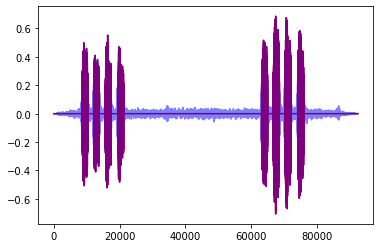

In [69]:
mask = np.argwhere(np.abs(waveform.numpy()) <0.2)
mask = mask.squeeze()

modified_wav = waveform.numpy()
modified_wav[mask] = 0
# for i in mask:
#     modified_wav[mask] = 0
plt.plot(modified_wav, c='r')
plt.plot(waveform, alpha=0.5, c='b')


In [70]:

tf.select(mask, tf.ones([4,8]), tf.zeros(4,8]))
tf.boolean_mask(waveform, mask) = 0
plt.plot(waveform.numpy())

SyntaxError: cannot assign to function call (<ipython-input-70-67c6319ed586>, line 2)